In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices(device_type=None)

import tensorflow.keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py

from keras import callbacks 
from sklearn.model_selection import KFold

In [2]:
# load data -------------------------------------------------

num = 4000 # number of profiles
nchan = 3 # number of channels

# get spatial dimension
fname = "Out1/profile_%05d.hdf5" %(1)
hf = h5py.File(fname, 'r')
spatial = hf.get('x') # HDF5 dataset "x": shape (4096,), type "<f8">
x = np.array(spatial) #change it to np array
x_size = np.size(np.array(spatial)) #4096; Dimension: (4096,)
hf.close()

data = np.empty((num, x_size, nchan+1), dtype=float)
for i in range(0, num):
    fname = "Out1/profile_%05d.hdf5" %(i+1)
    hf = h5py.File(fname, 'r')
    data[i, :, 0] = np.array(hf.get("red"))
    data[i, :, 1] = np.array(hf.get("grn"))
    data[i, :, 2] = np.array(hf.get("blu"))
    data[i, :, 3] = np.array(hf.get("tau")) #data.shape: (4000, 4096, 4) 4000 profiles, 4096 pixels, 3 channels 
    hf.close()

#np.random.seed(4); #same set of numbers will appear every time
#np.random.shuffle(data) #number will be in the same order in data

# allocate for training and testing -------------------------
trp = 0.8; # percent to train and validate
train_size=int(trp*num)
test_size = num - train_size 

# spatial slicing dimensions
os = 8 # output slice size
halo = 2; # edge cells
ts = os + halo * 2 # total input slice size including halos 12
ks = int(ts / 2) # kernel size is half of total size 6
l2r = 511; # number of slices in one profile 



In [3]:
print(train_size,test_size)

3200 800


In [4]:
image=np.zeros((l2r*num,ts,3)) 
label=np.zeros((l2r*num,os)) 
for i in range(l2r):
#cut each profile into 511 slices. 
#label: tau channel of the center of each slice(reduced domain), they ignore the edge pixel.
    img= data[:, i*os:i*os+ts, 0:nchan] #input: 12 pixels for one slice, 3 channels 
    lb = data[:, i*os+halo:i*os+halo+os, nchan] #8 pixels for label,the tau channel is the label
    image[i*num:i*num+num]=img
    label[i*num:i*num+num,:]=lb 
print('whole dataset features size: ',image.shape,'whole dataset label size: ', label.shape) #511*4000=

whole dataset features size:  (2044000, 12, 3) whole dataset label size:  (2044000, 8)


In [5]:
predictions = np.empty((test_size,8)) 
predictions.shape

(800, 8)

In [6]:
# CNN over domain -------------------------------------------
ltype = 'mean_squared_error'
bsize = 1024
eps = 500

def evaluate_model(train_image, test_image, train_label, test_label):

    model_m = models.Sequential()
    model_m.add(layers.Conv1D(nchan*100, kernel_size=ks, activation='relu', input_shape=(ts, nchan))) #kernel size 6, 100 filters for each 3 channel
    model_m.add(layers.Conv1D(8, kernel_size=1))#8 filters, kernel size 1
    model_m.add(layers.Dropout(0.5))
    model_m.add(layers.Flatten())
    model_m.add(layers.Dense(os, activation="linear"))#output slice size : 8

    model_m.summary()



    model_m.compile(optimizer='adam',loss=ltype,metrics=[ltype])

    #earlystopping to find the optimal number of epochs 
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                                mode ="min", patience = 25,  
                                                restore_best_weights = True,
                                               verbose=1) 

    history = model_m.fit(train_image,train_label,batch_size = bsize,epochs = eps,validation_split=0.1875,
                              callbacks =[earlystopping])#validation set(15%)/trainset(80%)=0.1875

    # test and predict ---------------------------------------------

    print('test result')
    results = model_m.evaluate(test_image, test_label)
    predictions=model_m.predict(test_image)
    mse = results[0]
    
    return model_m,mse,history,predictions

In [48]:
n_folds=5

kf = KFold(n_splits=n_folds)
kf.get_n_splits(image)
print(kf)
ratio=int(image.shape[0]/n_folds)

X_train=np.zeros((n_folds,ratio*(n_folds-1),12,3))
y_train=np.zeros((n_folds,ratio*(n_folds-1),8))
X_test=np.zeros((n_folds,ratio,12,3))
y_test=np.zeros((n_folds,ratio,8))

count=0
for train_index, test_index in kf.split(image):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train[count], X_test[count] = image[train_index], image[test_index]
    y_train[count], y_test[count] = label[train_index], label[test_index]
    count+=1

KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [ 408800  408801  408802 ... 2043997 2043998 2043999] TEST: [     0      1      2 ... 408797 408798 408799]
TRAIN: [      0       1       2 ... 2043997 2043998 2043999] TEST: [408800 408801 408802 ... 817597 817598 817599]
TRAIN: [      0       1       2 ... 2043997 2043998 2043999] TEST: [ 817600  817601  817602 ... 1226397 1226398 1226399]
TRAIN: [      0       1       2 ... 2043997 2043998 2043999] TEST: [1226400 1226401 1226402 ... 1635197 1635198 1635199]
TRAIN: [      0       1       2 ... 1635197 1635198 1635199] TEST: [1635200 1635201 1635202 ... 2043997 2043998 2043999]


In [10]:
cv_scores, model_history = list(), list()
for n in range(n_folds):
    # split data
    train_image, test_image, train_label, test_label = X_train[n],X_test[n],y_train[n],y_test[n]
    # evaluate model
    model_m,mse,history,predictions= evaluate_model(train_image, test_image, train_label, test_label)
    print('MSE on test set in fold'+str(n+1)+' : '+str(mse))
    cv_scores.append(mse)
    
    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 7, 300)            5700      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7, 8)              2408      
_________________________________________________________________
dropout (Dropout)            (None, 7, 8)              0         
_________________________________________________________________
flatten (Flatten)            (None, 56)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 456       
Total params: 8,564
Trainable params: 8,564
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
1298/1298 [==============================] - 15s 8ms/step - loss: 36.8426 - mean_squared_error: 36.8426 - va

1298/1298 [==============================] - 6s 5ms/step - loss: 16.4488 - mean_squared_error: 16.4488 - val_loss: 14.9719 - val_mean_squared_error: 14.9719
Epoch 44/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.2897 - mean_squared_error: 16.2897 - val_loss: 15.3296 - val_mean_squared_error: 15.3296
Epoch 45/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.5790 - mean_squared_error: 16.5790 - val_loss: 15.1361 - val_mean_squared_error: 15.1361
Epoch 46/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.3888 - mean_squared_error: 16.3888 - val_loss: 15.9441 - val_mean_squared_error: 15.9441
Epoch 47/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.2452 - mean_squared_error: 16.2452 - val_loss: 14.8301 - val_mean_squared_error: 14.8301
Epoch 48/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.2454 - mean_squared_error: 16.2454 - val_loss: 15.6767 - val_mean_squared_error: 1

1298/1298 [==============================] - 6s 5ms/step - loss: 16.1952 - mean_squared_error: 16.1952 - val_loss: 15.6122 - val_mean_squared_error: 15.6122
Epoch 92/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.0314 - mean_squared_error: 16.0314 - val_loss: 15.1922 - val_mean_squared_error: 15.1922
Epoch 93/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.8473 - mean_squared_error: 15.8473 - val_loss: 14.8228 - val_mean_squared_error: 14.8228
Epoch 94/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.1362 - mean_squared_error: 16.1362 - val_loss: 15.1844 - val_mean_squared_error: 15.1844
Epoch 95/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.8249 - mean_squared_error: 15.8249 - val_loss: 14.6162 - val_mean_squared_error: 14.6162
Epoch 96/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.9052 - mean_squared_error: 15.9052 - val_loss: 15.1349 - val_mean_squared_error: 1

Epoch 3/500
1298/1298 [==============================] - 6s 5ms/step - loss: 23.0279 - mean_squared_error: 23.0279 - val_loss: 21.0089 - val_mean_squared_error: 21.0089
Epoch 4/500
1298/1298 [==============================] - 6s 5ms/step - loss: 22.6509 - mean_squared_error: 22.6509 - val_loss: 20.3686 - val_mean_squared_error: 20.3686
Epoch 5/500
1298/1298 [==============================] - 6s 5ms/step - loss: 22.7616 - mean_squared_error: 22.7616 - val_loss: 20.6006 - val_mean_squared_error: 20.6006
Epoch 6/500
1298/1298 [==============================] - 6s 5ms/step - loss: 22.1360 - mean_squared_error: 22.1360 - val_loss: 20.0050 - val_mean_squared_error: 20.0050
Epoch 7/500
1298/1298 [==============================] - 6s 5ms/step - loss: 21.9066 - mean_squared_error: 21.9066 - val_loss: 20.1051 - val_mean_squared_error: 20.1051
Epoch 8/500
1298/1298 [==============================] - 6s 5ms/step - loss: 21.8731 - mean_squared_error: 21.8731 - val_loss: 20.0667 - val_mean_squared_e

1298/1298 [==============================] - 6s 5ms/step - loss: 17.9292 - mean_squared_error: 17.9292 - val_loss: 16.8322 - val_mean_squared_error: 16.8322
Epoch 52/500
1298/1298 [==============================] - 6s 5ms/step - loss: 18.0657 - mean_squared_error: 18.0657 - val_loss: 16.1490 - val_mean_squared_error: 16.1490
Epoch 53/500
1298/1298 [==============================] - 6s 5ms/step - loss: 17.8176 - mean_squared_error: 17.8176 - val_loss: 16.4024 - val_mean_squared_error: 16.4024
Epoch 54/500
1298/1298 [==============================] - 6s 5ms/step - loss: 17.5142 - mean_squared_error: 17.5142 - val_loss: 16.5724 - val_mean_squared_error: 16.5724
Epoch 55/500
1298/1298 [==============================] - 6s 5ms/step - loss: 17.5711 - mean_squared_error: 17.5711 - val_loss: 16.5820 - val_mean_squared_error: 16.5820
Epoch 56/500
1298/1298 [==============================] - 6s 5ms/step - loss: 17.6283 - mean_squared_error: 17.6283 - val_loss: 16.3189 - val_mean_squared_error: 1

1298/1298 [==============================] - 6s 5ms/step - loss: 16.1915 - mean_squared_error: 16.1915 - val_loss: 14.5871 - val_mean_squared_error: 14.5871
Epoch 100/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.0307 - mean_squared_error: 16.0307 - val_loss: 15.6110 - val_mean_squared_error: 15.6110
Epoch 101/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.3642 - mean_squared_error: 16.3642 - val_loss: 14.4597 - val_mean_squared_error: 14.4597
Epoch 102/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.9631 - mean_squared_error: 15.9631 - val_loss: 14.5566 - val_mean_squared_error: 14.5566
Epoch 103/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.0304 - mean_squared_error: 16.0304 - val_loss: 14.6778 - val_mean_squared_error: 14.6778
Epoch 104/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.0235 - mean_squared_error: 16.0235 - val_loss: 14.5303 - val_mean_squared_err

Epoch 147/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.9759 - mean_squared_error: 15.9759 - val_loss: 15.4175 - val_mean_squared_error: 15.4175
Epoch 148/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.0474 - mean_squared_error: 16.0474 - val_loss: 14.4650 - val_mean_squared_error: 14.4650
Epoch 149/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.7987 - mean_squared_error: 15.7987 - val_loss: 14.2546 - val_mean_squared_error: 14.2546
Epoch 150/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.0005 - mean_squared_error: 16.0005 - val_loss: 14.2841 - val_mean_squared_error: 14.2841
Epoch 151/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.0713 - mean_squared_error: 16.0713 - val_loss: 14.5602 - val_mean_squared_error: 14.5602
Epoch 152/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.8513 - mean_squared_error: 15.8513 - val_loss: 14.4445 - val_me

Epoch 195/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.9238 - mean_squared_error: 15.9238 - val_loss: 14.1559 - val_mean_squared_error: 14.1559
Epoch 196/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.7539 - mean_squared_error: 15.7539 - val_loss: 14.5305 - val_mean_squared_error: 14.5305
Epoch 197/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.8003 - mean_squared_error: 15.8003 - val_loss: 14.1786 - val_mean_squared_error: 14.1786
Epoch 198/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.0582 - mean_squared_error: 16.0582 - val_loss: 14.0568 - val_mean_squared_error: 14.0568
Epoch 199/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.7989 - mean_squared_error: 15.7989 - val_loss: 14.6058 - val_mean_squared_error: 14.6058
Epoch 200/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.7197 - mean_squared_error: 15.7197 - val_loss: 14.2676 - val_me

Epoch 19/500
1298/1298 [==============================] - 6s 5ms/step - loss: 18.2843 - mean_squared_error: 18.2843 - val_loss: 17.6183 - val_mean_squared_error: 17.6183
Epoch 20/500
1298/1298 [==============================] - 6s 5ms/step - loss: 18.2900 - mean_squared_error: 18.2900 - val_loss: 18.6388 - val_mean_squared_error: 18.6388
Epoch 21/500
1298/1298 [==============================] - 6s 5ms/step - loss: 18.2586 - mean_squared_error: 18.2586 - val_loss: 18.0070 - val_mean_squared_error: 18.0070
Epoch 22/500
1298/1298 [==============================] - 6s 5ms/step - loss: 17.8810 - mean_squared_error: 17.8810 - val_loss: 17.6670 - val_mean_squared_error: 17.6670
Epoch 23/500
1298/1298 [==============================] - 6s 5ms/step - loss: 18.1673 - mean_squared_error: 18.1673 - val_loss: 16.9668 - val_mean_squared_error: 16.9668
Epoch 24/500
1298/1298 [==============================] - 6s 5ms/step - loss: 18.0572 - mean_squared_error: 18.0572 - val_loss: 17.2143 - val_mean_squ

1298/1298 [==============================] - 6s 5ms/step - loss: 16.9200 - mean_squared_error: 16.9200 - val_loss: 16.3344 - val_mean_squared_error: 16.3344
Epoch 68/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.6269 - mean_squared_error: 16.6269 - val_loss: 15.7035 - val_mean_squared_error: 15.7035
Epoch 69/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.4495 - mean_squared_error: 16.4495 - val_loss: 16.0672 - val_mean_squared_error: 16.0672
Epoch 70/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.5794 - mean_squared_error: 16.5794 - val_loss: 15.6420 - val_mean_squared_error: 15.6420
Epoch 71/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.7884 - mean_squared_error: 16.7884 - val_loss: 16.7371 - val_mean_squared_error: 16.7371
Epoch 72/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.5468 - mean_squared_error: 16.5468 - val_loss: 16.4100 - val_mean_squared_error: 1

1298/1298 [==============================] - 6s 5ms/step - loss: 16.4090 - mean_squared_error: 16.4090 - val_loss: 14.9646 - val_mean_squared_error: 14.9646
Epoch 116/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.5776 - mean_squared_error: 16.5776 - val_loss: 15.5616 - val_mean_squared_error: 15.5616
Epoch 117/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.3003 - mean_squared_error: 16.3003 - val_loss: 16.0773 - val_mean_squared_error: 16.0773
Epoch 118/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.4287 - mean_squared_error: 16.4287 - val_loss: 16.0540 - val_mean_squared_error: 16.0540
Epoch 119/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.3748 - mean_squared_error: 16.3748 - val_loss: 15.5911 - val_mean_squared_error: 15.5911
Epoch 120/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.3596 - mean_squared_error: 16.3596 - val_loss: 15.0865 - val_mean_squared_err

Epoch 163/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.9210 - mean_squared_error: 15.9210 - val_loss: 14.6949 - val_mean_squared_error: 14.6949
Epoch 164/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.9559 - mean_squared_error: 15.9559 - val_loss: 15.0273 - val_mean_squared_error: 15.0273
Epoch 165/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.9083 - mean_squared_error: 15.9083 - val_loss: 14.3122 - val_mean_squared_error: 14.3122
Epoch 166/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.9545 - mean_squared_error: 15.9545 - val_loss: 16.1232 - val_mean_squared_error: 16.1232
Epoch 167/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.8900 - mean_squared_error: 15.8900 - val_loss: 14.5769 - val_mean_squared_error: 14.5769
Epoch 168/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.0609 - mean_squared_error: 16.0609 - val_loss: 14.7853 - val_me

Epoch 14/500
1298/1298 [==============================] - 6s 5ms/step - loss: 18.5945 - mean_squared_error: 18.5945 - val_loss: 18.0835 - val_mean_squared_error: 18.0835
Epoch 15/500
1298/1298 [==============================] - 6s 5ms/step - loss: 18.1131 - mean_squared_error: 18.1131 - val_loss: 17.8516 - val_mean_squared_error: 17.8516
Epoch 16/500
1298/1298 [==============================] - 6s 5ms/step - loss: 17.9974 - mean_squared_error: 17.9974 - val_loss: 17.3839 - val_mean_squared_error: 17.3839
Epoch 17/500
1298/1298 [==============================] - 6s 5ms/step - loss: 17.8229 - mean_squared_error: 17.8229 - val_loss: 16.9902 - val_mean_squared_error: 16.9902
Epoch 18/500
1298/1298 [==============================] - 6s 5ms/step - loss: 18.0692 - mean_squared_error: 18.0692 - val_loss: 17.2035 - val_mean_squared_error: 17.2035
Epoch 19/500
1298/1298 [==============================] - 6s 5ms/step - loss: 17.8605 - mean_squared_error: 17.8605 - val_loss: 17.4663 - val_mean_squ

1298/1298 [==============================] - 6s 5ms/step - loss: 17.1339 - mean_squared_error: 17.1339 - val_loss: 16.9077 - val_mean_squared_error: 16.9077
Epoch 63/500
1298/1298 [==============================] - 6s 5ms/step - loss: 17.0887 - mean_squared_error: 17.0887 - val_loss: 17.0497 - val_mean_squared_error: 17.0497
Epoch 64/500
1298/1298 [==============================] - 6s 5ms/step - loss: 17.0837 - mean_squared_error: 17.0837 - val_loss: 16.6167 - val_mean_squared_error: 16.6167
Epoch 65/500
1298/1298 [==============================] - 6s 5ms/step - loss: 17.1456 - mean_squared_error: 17.1456 - val_loss: 16.4112 - val_mean_squared_error: 16.4112
Epoch 66/500
1298/1298 [==============================] - 6s 5ms/step - loss: 17.1113 - mean_squared_error: 17.1113 - val_loss: 16.3267 - val_mean_squared_error: 16.3267
Epoch 67/500
1298/1298 [==============================] - 6s 5ms/step - loss: 17.0896 - mean_squared_error: 17.0896 - val_loss: 16.1261 - val_mean_squared_error: 1

1298/1298 [==============================] - 6s 5ms/step - loss: 16.0749 - mean_squared_error: 16.0749 - val_loss: 15.0969 - val_mean_squared_error: 15.0969
Epoch 111/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.9300 - mean_squared_error: 15.9300 - val_loss: 14.9445 - val_mean_squared_error: 14.9445
Epoch 112/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.1846 - mean_squared_error: 16.1846 - val_loss: 14.9217 - val_mean_squared_error: 14.9217
Epoch 113/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.0308 - mean_squared_error: 16.0308 - val_loss: 14.9185 - val_mean_squared_error: 14.9185
Epoch 114/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.3379 - mean_squared_error: 16.3379 - val_loss: 15.5887 - val_mean_squared_error: 15.5887
Epoch 115/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.0595 - mean_squared_error: 16.0595 - val_loss: 15.4251 - val_mean_squared_err

Epoch 158/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.5854 - mean_squared_error: 15.5854 - val_loss: 15.5585 - val_mean_squared_error: 15.5585
Epoch 159/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.8206 - mean_squared_error: 15.8206 - val_loss: 15.1018 - val_mean_squared_error: 15.1018
Epoch 160/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.6386 - mean_squared_error: 15.6386 - val_loss: 14.8099 - val_mean_squared_error: 14.8099
Epoch 161/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.9238 - mean_squared_error: 15.9238 - val_loss: 14.5408 - val_mean_squared_error: 14.5408
Epoch 162/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.6435 - mean_squared_error: 15.6435 - val_loss: 15.9015 - val_mean_squared_error: 15.9015
Epoch 163/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.6522 - mean_squared_error: 15.6522 - val_loss: 15.0826 - val_me

Epoch 206/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.4482 - mean_squared_error: 15.4482 - val_loss: 14.1820 - val_mean_squared_error: 14.1820
Epoch 207/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.4997 - mean_squared_error: 15.4997 - val_loss: 14.3167 - val_mean_squared_error: 14.3167
Epoch 208/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.4644 - mean_squared_error: 15.4644 - val_loss: 14.3564 - val_mean_squared_error: 14.3564
Epoch 209/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.4843 - mean_squared_error: 15.4843 - val_loss: 14.4715 - val_mean_squared_error: 14.4715
Epoch 210/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.1550 - mean_squared_error: 15.1550 - val_loss: 14.1935 - val_mean_squared_error: 14.1935
Epoch 211/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.3462 - mean_squared_error: 15.3462 - val_loss: 14.3295 - val_me

Epoch 19/500
1298/1298 [==============================] - 6s 5ms/step - loss: 18.4269 - mean_squared_error: 18.4269 - val_loss: 17.5148 - val_mean_squared_error: 17.5148
Epoch 20/500
1298/1298 [==============================] - 6s 5ms/step - loss: 18.1561 - mean_squared_error: 18.1561 - val_loss: 17.3977 - val_mean_squared_error: 17.3977
Epoch 21/500
1298/1298 [==============================] - 6s 5ms/step - loss: 18.0640 - mean_squared_error: 18.0640 - val_loss: 16.9151 - val_mean_squared_error: 16.9151
Epoch 22/500
1298/1298 [==============================] - 6s 5ms/step - loss: 17.7987 - mean_squared_error: 17.7987 - val_loss: 17.6846 - val_mean_squared_error: 17.6846
Epoch 23/500
1298/1298 [==============================] - 6s 5ms/step - loss: 18.0074 - mean_squared_error: 18.0074 - val_loss: 18.2530 - val_mean_squared_error: 18.2530
Epoch 24/500
1298/1298 [==============================] - 6s 5ms/step - loss: 17.9322 - mean_squared_error: 17.9322 - val_loss: 16.9158 - val_mean_squ

1298/1298 [==============================] - 6s 5ms/step - loss: 16.4694 - mean_squared_error: 16.4694 - val_loss: 15.5993 - val_mean_squared_error: 15.5993
Epoch 68/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.4248 - mean_squared_error: 16.4248 - val_loss: 15.5883 - val_mean_squared_error: 15.5883
Epoch 69/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.6128 - mean_squared_error: 16.6128 - val_loss: 15.5289 - val_mean_squared_error: 15.5289
Epoch 70/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.5795 - mean_squared_error: 16.5795 - val_loss: 15.6513 - val_mean_squared_error: 15.6513
Epoch 71/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.6678 - mean_squared_error: 16.6678 - val_loss: 16.0822 - val_mean_squared_error: 16.0822
Epoch 72/500
1298/1298 [==============================] - 6s 5ms/step - loss: 16.7484 - mean_squared_error: 16.7484 - val_loss: 15.5077 - val_mean_squared_error: 1

1298/1298 [==============================] - 6s 5ms/step - loss: 15.6979 - mean_squared_error: 15.6979 - val_loss: 14.4378 - val_mean_squared_error: 14.4378
Epoch 116/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.6475 - mean_squared_error: 15.6475 - val_loss: 15.3893 - val_mean_squared_error: 15.3893
Epoch 117/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.7501 - mean_squared_error: 15.7501 - val_loss: 15.2769 - val_mean_squared_error: 15.2769
Epoch 118/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.7409 - mean_squared_error: 15.7409 - val_loss: 14.6359 - val_mean_squared_error: 14.6359
Epoch 119/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.6819 - mean_squared_error: 15.6819 - val_loss: 14.9834 - val_mean_squared_error: 14.9834
Epoch 120/500
1298/1298 [==============================] - 6s 5ms/step - loss: 15.6475 - mean_squared_error: 15.6475 - val_loss: 14.2271 - val_mean_squared_err

In [45]:
#quantitative result: average MSE on test set and its standard deviation
print('Estimated MSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores),np.std(cv_scores)))

Estimated MSE 13.9955 with standard deviation (0.7223)


In [12]:
predictions.shape

(408800, 8)

In [13]:
test_image.shape

(408800, 12, 3)

The optimal number of epochs is 120 in the last fold.


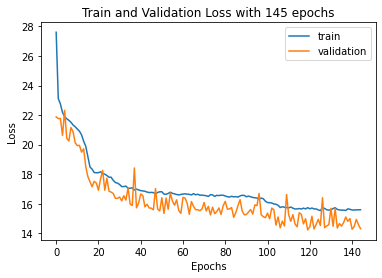

In [17]:
patience=25
# plot training and validation history in the last fold
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.title('Train and Validation Loss with '+str(len(history.history['val_loss']))+' epochs')
plt.legend()
 
plt.savefig('train_validation_after_'+str(len(history.history['val_loss'])-patience)+"_epochs.png")

print('The optimal number of epochs is '+str(len(history.history['val_loss'])-patience)+' in the last fold.')


In [26]:
test_size

800

In [25]:
predictions[1]

array([2.751174 , 2.7189345, 2.6860147, 2.6981082, 2.6393661, 2.6065497,
       2.2454276, 2.256918 ], dtype=float32)

In [20]:
predict1=np.zeros((511,8))
for i in range(511):
    predict1[i]=predictions[i*test_size+test_size-3]
    
predict2=np.zeros((511,8))
for i in range(511):
    predict2[i]=predictions[i*test_size+test_size-2]
    
predict3=np.zeros((511,8))
for i in range(511):
    predict3[i]=predictions[i*test_size+test_size-1]

In [22]:
a=predict1.reshape(4088)

In [44]:
predictions.shape

(408800, 8)

In [41]:
label[ratio*(n_folds-1)+test_size-3+test_size*1,:]

array([20.8068149 , 22.67431522, 25.93653409, 23.80035114, 23.29351591,
       21.37501703, 32.01298118, 29.37633033])